# Diabetes classification with XGBoost

Predict whether a person has **any** form of diabetes (prediabetes or diabetes) using gradient-boosted trees (XGBoost) on the BRFSS 2015 health indicators dataset.

We follow the Phase II progress report methodology: merge prediabetes + diabetes into a single positive class, handle class imbalance, and evaluate using ROC-AUC, PR-AUC, recall, F1, and accuracy.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc,
)

from xgboost import XGBClassifier

DATA_PATH = Path("diabetes_binary_5050split_health_indicators_BRFSS2015.csv")

df = pd.read_csv(DATA_PATH)

target_col = "Diabetes_binary"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].values
y = df[target_col].values.astype(int)

print(f"Features shape: {X.shape}")
print("Class distribution (0=no diabetes, 1=any diabetes):")
unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  class {cls}: {cnt} samples ({cnt / len(y):.3f} share)")


Features shape: (70692, 21)
Class distribution (0=no diabetes, 1=any diabetes):
  class 0: 35346 samples (0.500 share)
  class 1: 35346 samples (0.500 share)


In [2]:
# Stratified train/validation/test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.2,
    stratify=y_train_full,
    random_state=42,
)

neg_train, pos_train = np.bincount(y_train)
scale_pos_weight_train = neg_train / pos_train

neg_full, pos_full = np.bincount(y_train_full)
scale_pos_weight_full = neg_full / pos_full

print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")
print(f"Positive class fraction (train subset): {pos_train / (neg_train + pos_train):.3f}")
print(f"scale_pos_weight (train subset): {scale_pos_weight_train:.2f}")


Train size: 45242, Val size: 11311, Test size: 14139
Positive class fraction (train subset): 0.500
scale_pos_weight (train subset): 1.00


In [3]:
def evaluate_model(name, y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)

    print(f"{name} metrics (threshold={threshold:.2f}):")
    print(f"  Accuracy : {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall   : {rec:.3f}")
    print(f"  F1-score : {f1:.3f}")
    print(f"  ROC-AUC  : {roc:.3f}")
    print(f"  PR-AUC   : {pr_auc:.3f}\n")

    print("Confusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3))


In [4]:
# Base XGBoost classifier configuration
base_params = dict(
    objective="binary:logistic",
    tree_method="hist",  # efficient for tabular data
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
)

xgb_clf = XGBClassifier(**base_params, scale_pos_weight=scale_pos_weight_train)

# Hyperparameter grid following the methodology in the report
param_grid = {
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [300, 500],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 5],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="roc_auc",  # optimize ROC-AUC as primary metric
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

print("Starting XGBoost grid search (this can take a while)...")

grid.fit(X_train, y_train)

print("Best hyperparameters (by CV ROC-AUC):")
print(grid.best_params_)
print(f"Best cross-validated ROC-AUC: {grid.best_score_:.4f}")

best_params = grid.best_params_
best_model = grid.best_estimator_

print("\nTuning decision threshold on the validation set...")
val_proba = best_model.predict_proba(X_val)[:, 1]
threshold_candidates = np.linspace(0.3, 0.7, 41)
best_thr = 0.5
best_f1 = -1.0

for t in threshold_candidates:
    preds_t = (val_proba >= t).astype(int)
    f1_t = f1_score(y_val, preds_t, zero_division=0)
    if f1_t > best_f1:
        best_f1 = f1_t
        best_thr = t

print(f"Best validation F1={best_f1:.4f} at threshold={best_thr:.3f}")

print("\nEvaluating best XGBoost model on the held-out test set...")
final_params = {**base_params, **best_params, "scale_pos_weight": scale_pos_weight_full}
final_model = XGBClassifier(**final_params)
final_model.fit(X_train_full, y_train_full)

y_test_proba = final_model.predict_proba(X_test)[:, 1]

evaluate_model("XGBoost (test, threshold=0.5)", y_test, y_test_proba, threshold=0.5)
evaluate_model("XGBoost (test, tuned threshold)", y_test, y_test_proba, threshold=best_thr)


Starting XGBoost grid search (this can take a while)...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best hyperparameters (by CV ROC-AUC):
{'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validated ROC-AUC: 0.8303

Tuning decision threshold on the validation set...
Best validation F1=0.7791 at threshold=0.370

Evaluating best XGBoost model on the held-out test set...
XGBoost (test, threshold=0.5) metrics (threshold=0.50):
  Accuracy : 0.754
  Precision: 0.734
  Recall   : 0.798
  F1-score : 0.764
  ROC-AUC  : 0.831
  PR-AUC   : 0.805

Confusion matrix (rows=true, cols=pred):
[[5026 2044]
 [1431 5638]]

Classification report:
              precision    recall  f1-score   support

           0      0.778     0.711     0.743      7070
           1      0.734     0.798     0.764      7069

    accuracy                          0.754     14139
   macro avg      0.756     0.754     0.754

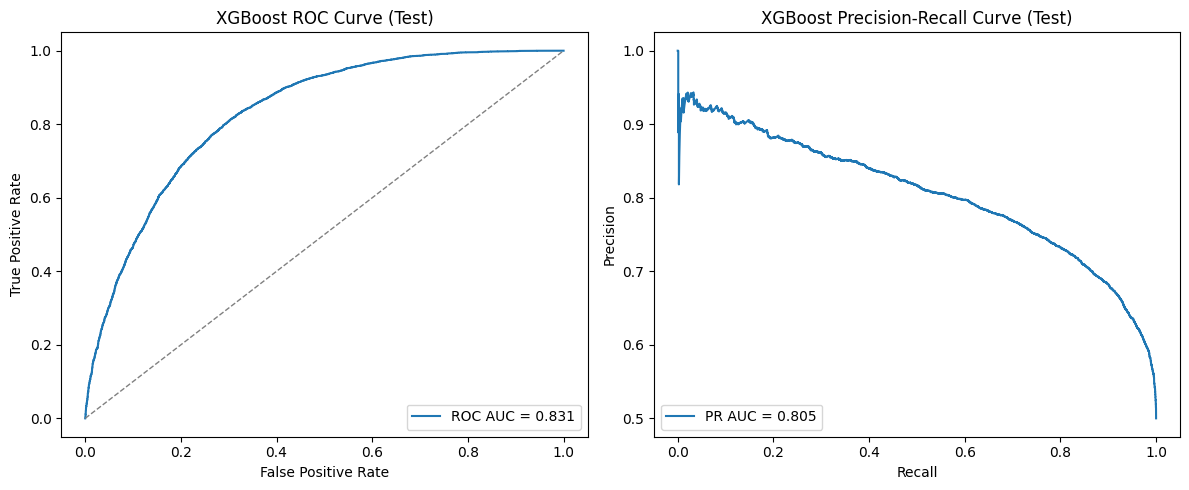

In [5]:
# ROC and Precision-Recall curves for the test set
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)
pr_auc = auc(recall, precision)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
ax[0].plot([0, 1], [0, 1], '--', color='gray', linewidth=1)
ax[0].set_title('XGBoost ROC Curve (Test)')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

ax[1].plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
ax[1].set_title('XGBoost Precision-Recall Curve (Test)')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(loc='lower left')

plt.tight_layout()
plt.show()


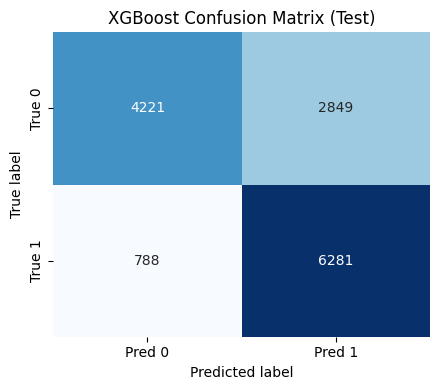

In [6]:
# Confusion matrix heatmap at tuned threshold
xgb_test_preds = (y_test_proba >= best_thr).astype(int)
cm = confusion_matrix(y_test, xgb_test_preds)
fig, ax = plt.subplots(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
ax.set_title('XGBoost Confusion Matrix (Test)')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
plt.tight_layout()
plt.show()


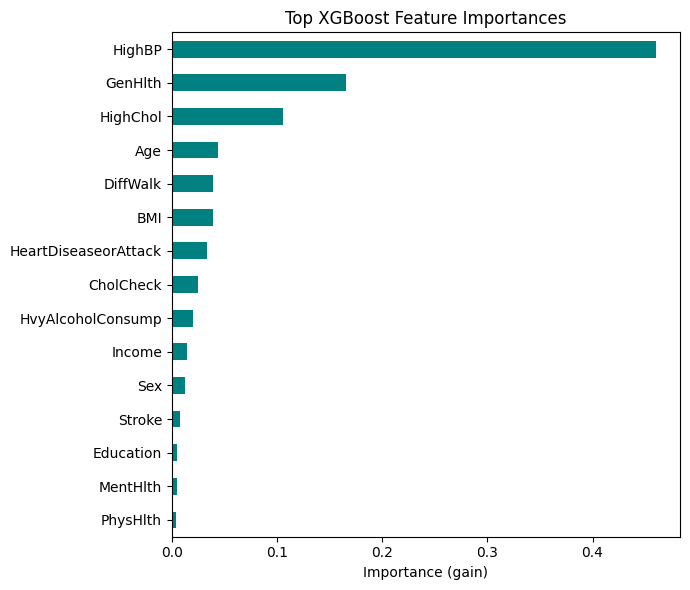

In [7]:
# Feature importance bar chart (gain-based)
importances = final_model.feature_importances_
importance_series = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
top_k = importance_series.head(15)

plt.figure(figsize=(7, 6))
top_k.iloc[::-1].plot(kind='barh', color='teal')
plt.title('Top XGBoost Feature Importances')
plt.xlabel('Importance (gain)')
plt.tight_layout()
plt.show()
